# Linear Regression Implementation

#### In this jupyter notebook, I implement a linear regression algorithm and use it to make predictions using dataset from: https://www.kaggle.com/datasets/krupadharamshi/fuelconsumption.  The data has 10 features per entry (car type), including the CO2 emissions, which we want to predict. However, only four of the metrics are numerical, since things like car make and model are included. 

##### Note: car year is numerical as well, but all cars are from 2000, so that column is not very useful.

#### Thus, the only numerical metrics we look at in order to predict CO2 emissions are engine size, number of cylinders, and fuel consumption, with the addition of gasoline type, since this can be encoded pretty easily and understandably (a 0 for regular gas and 1 for premium gas). We can use this code to see which two of these four features help the model make the best predictions on CO2 emissions.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Import & Filter the data

In [2]:
# Step 2: Load the dataset
df = pd.read_csv("FuelConsumption.csv")

# Preview the first few rows
df.head()

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,15.0,301
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.4,230


In [3]:
# Filter for rows with FUEL type X or Z only
df = df[df["FUEL"].isin(["X", "Z"])].copy()

# Encode FUEL: X -> 0, Z -> 1
df["FUEL_ENCODED"] = df["FUEL"].map({"X": 0, "Z": 1})

features = ["ENGINE SIZE", "CYLINDERS", "FUEL CONSUMPTION", "FUEL_ENCODED"]
target = "COEMISSIONS "

## Linear Regression Algorithm

The function below runs a two-feature linear regression training on a subset of the data-set. With the rest of the data, it  makes predictions, which we can evaluate via an optional plot parameter. 

In [4]:
def evaluate_linear_regression(df, feature1, feature2, target="COEMISSIONS ", plot=False):
    """
    Trains and evaluates a two-feature linear regression model.

    Parameters:
        df (pd.DataFrame): Filtered and preprocessed dataset.
        feature1 (str): Name of first feature column.
        feature2 (str): Name of second feature column.
        target (str): Name of target column (default = "COEMISSIONS").
        plot (bool): Whether to show a predicted vs. actual plot.

    Returns:
        dict: Contains feature names, R² score, and MSE.
    """
    # Prepare input and output
    X = df[[feature1, feature2]].values
    y = df[target].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    ) #test_size=0.2: 20% of the data goes to the test set, 80% to training

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Optional plot
    if plot:
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual CO₂ Emissions")
        plt.ylabel("Predicted CO₂ Emissions")
        plt.title(f"{feature1} + {feature2} → R²: {r2:.3f}, MSE: {mse:.1f}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "features": (feature1, feature2),
        "r2": r2,
        "mse": mse
    }


## Result

Here, I run the algorithm on all the possible combinations of 2 features I can (because we only have 4 features, this is 6 in total). The R^2 score and MSE for each of the 6 runs is saved and a table displaying the results for each run is below. According to intuition, the closer the R^2 is to 1, the lower the mean squared error (MSE). Thus, both of these metrics agree on which pairing of features correlates the most to CO2 emissions: Fuel consumption and fuel_encoded (the gasoline type variable, regular or premium, discussed earlier).

In [5]:
# Store results
results = []

# Loop through all combinations of 2 features
for feature_pair in itertools.combinations(features, 2):
    f1, f2 = feature_pair
    result = evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=False)
    results.append(result)

# Sort results by R² (descending = best to worst)
results.sort(key=lambda x: x["r2"], reverse=True)

# Print as a table
print(f"{'Feature 1':<20} {'Feature 2':<20} {'R² Score':>10} {'MSE':>10}")
print("-" * 60)
for res in results:
    f1, f2 = res["features"]
    r2 = res["r2"]
    mse = res["mse"]
    print(f"{f1:<20} {f2:<20} {r2:10.4f} {mse:10.2f}")

Feature 1            Feature 2              R² Score        MSE
------------------------------------------------------------
FUEL CONSUMPTION     FUEL_ENCODED             0.9851      77.67
CYLINDERS            FUEL CONSUMPTION         0.9843      81.99
ENGINE SIZE          FUEL CONSUMPTION         0.9805     102.05
CYLINDERS            FUEL_ENCODED             0.7756    1172.36
ENGINE SIZE          CYLINDERS                0.7636    1235.48
ENGINE SIZE          FUEL_ENCODED             0.7461    1326.78


It is not too surprising that fuel consumption is so tightly correlated with co2 emissions. In fact, all three of the pairings with fuel consumption in them reached an R^2 score of >0.98. However, it is suprising that the variable which we chose to encode in order to include in our analysis (as it was not initially in numerical values) is the second half of the best pairing, slightly beating out fuel consumption's pairings with cylinders and engine size. In this case it was fruitful to encode a non-numerical feature.

### Prediction Accuracy Plots in Order from Best to Worst

In this section, we print out the plots of the six 2-feature pairings in order from best to worst. There are two types of plots we show. The first is found within the linear regression algorithm function, and it shows the deviation of predictions to actual values that the model has with the training set. 

The functions for the second plot, a colored scattered plot, is given below. It is more akin to the plots from the Perceptron folder because it plots each feature evaluated on the x- and y- axis respectively, then uses color to display the output. The output here is not a single classification (like red or blue), so the color goes from dark purple to light yellow in a continous fashion to indicate increase in the CO2 emission value.

In [6]:
def plot_feature_pair_with_emissions(df, feature1, feature2, target="COEMISSIONS "):
    """
    Plots a scatter plot of two features, colored by CO₂ emissions.
    
    Parameters:
        df (pd.DataFrame): The data frame with the features and target
        feature1 (str): Name of the x-axis feature
        feature2 (str): Name of the y-axis feature
        target (str): Name of the target column (default = 'COEMISSIONS')
    """
    x = df[feature1]
    y = df[feature2]
    color = df[target]

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x, y, c=color, cmap='viridis', edgecolor='k', alpha=0.8)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f"{feature1} vs {feature2} colored by {target}")
    cbar = plt.colorbar(scatter)
    cbar.set_label(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Top Combo: FUEL CONSUMPTION + FUEL_ENCODED


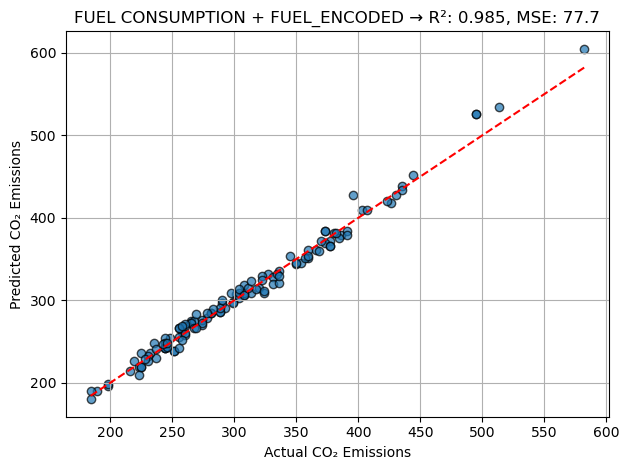

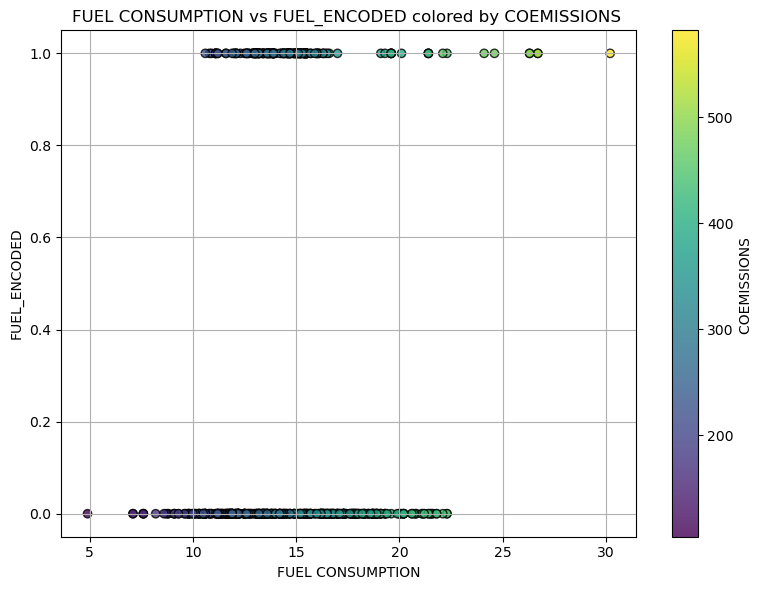

In [7]:
f1, f2 = results[0]["features"]
print(f"Top Combo: {f1} + {f2}")
evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=True)
plot_feature_pair_with_emissions(df, f1, f2, target="COEMISSIONS ")


2nd Best Combo: CYLINDERS + FUEL CONSUMPTION


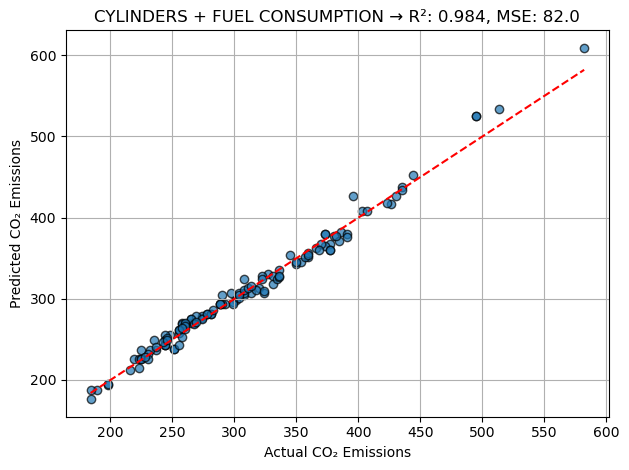

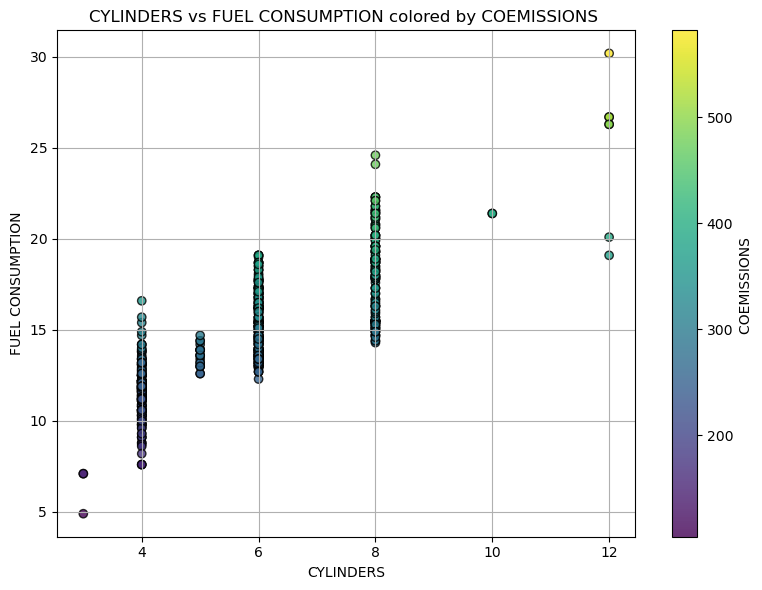

In [8]:
f1, f2 = results[1]["features"]
print(f"2nd Best Combo: {f1} + {f2}")
evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=True)
plot_feature_pair_with_emissions(df, f1, f2, target="COEMISSIONS ")

3rd Best Combo: ENGINE SIZE + FUEL CONSUMPTION


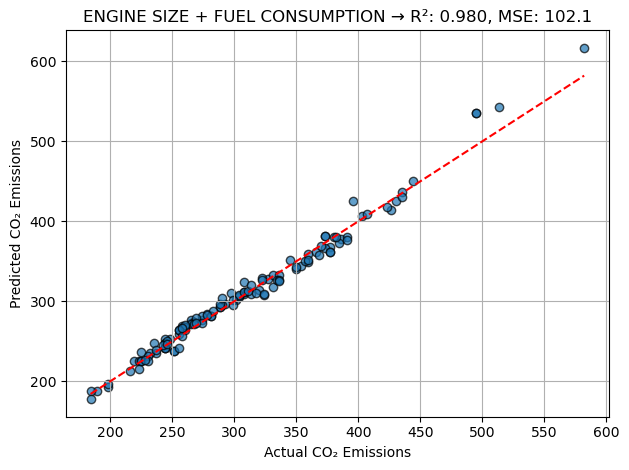

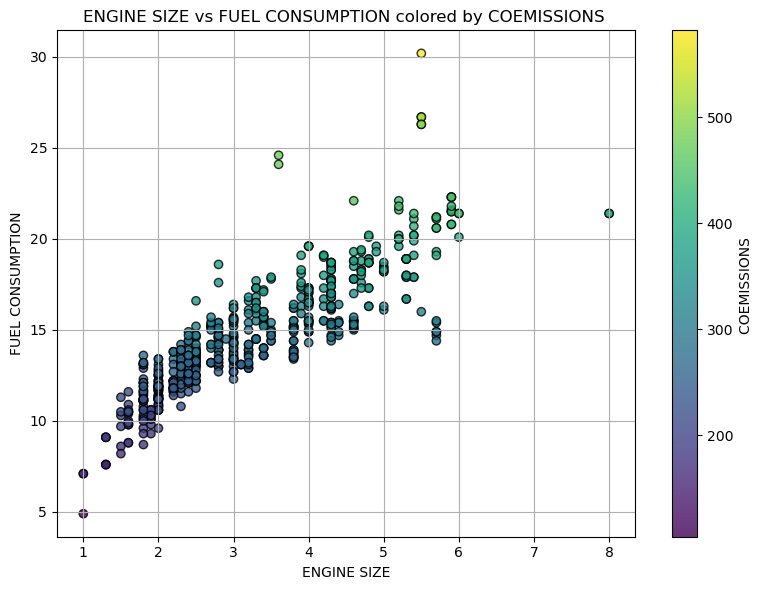

In [9]:
f1, f2 = results[2]["features"]
print(f"3rd Best Combo: {f1} + {f2}")
evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=True)
plot_feature_pair_with_emissions(df, f1, f2, target="COEMISSIONS ")


4th Best Combo: CYLINDERS + FUEL_ENCODED


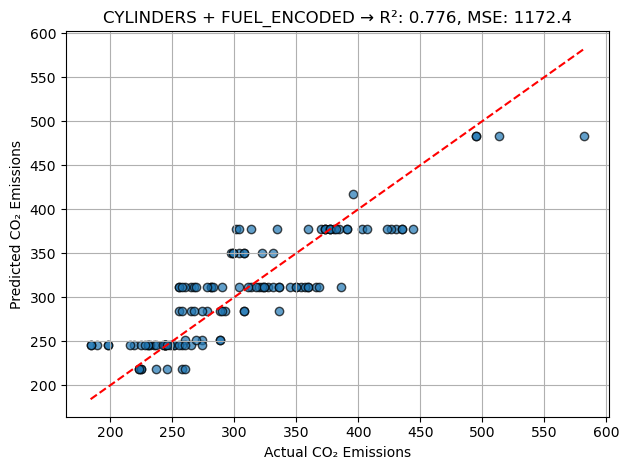

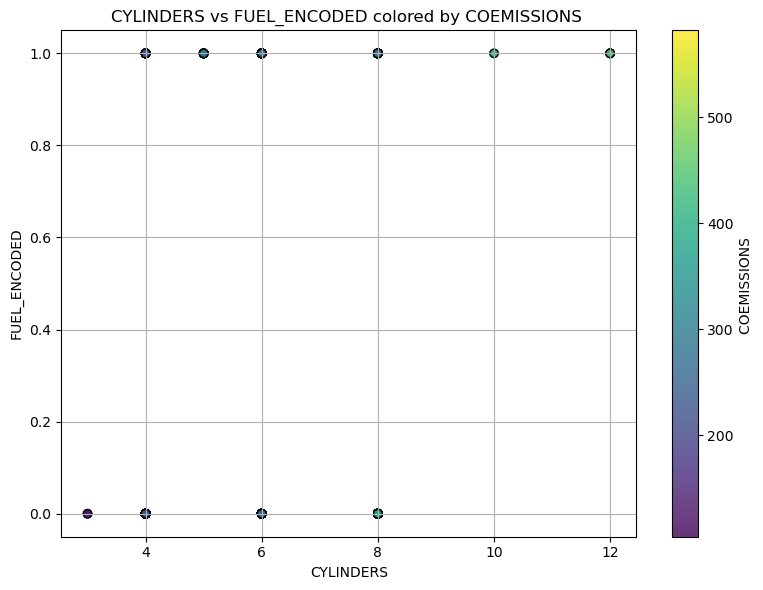

In [10]:
f1, f2 = results[3]["features"]
print(f"4th Best Combo: {f1} + {f2}")
evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=True)
plot_feature_pair_with_emissions(df, f1, f2, target="COEMISSIONS ")


5th Best (and 2nd Worst) Combo: ENGINE SIZE + CYLINDERS


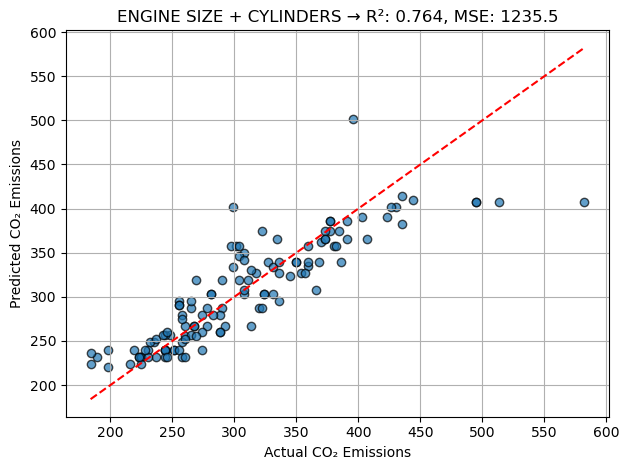

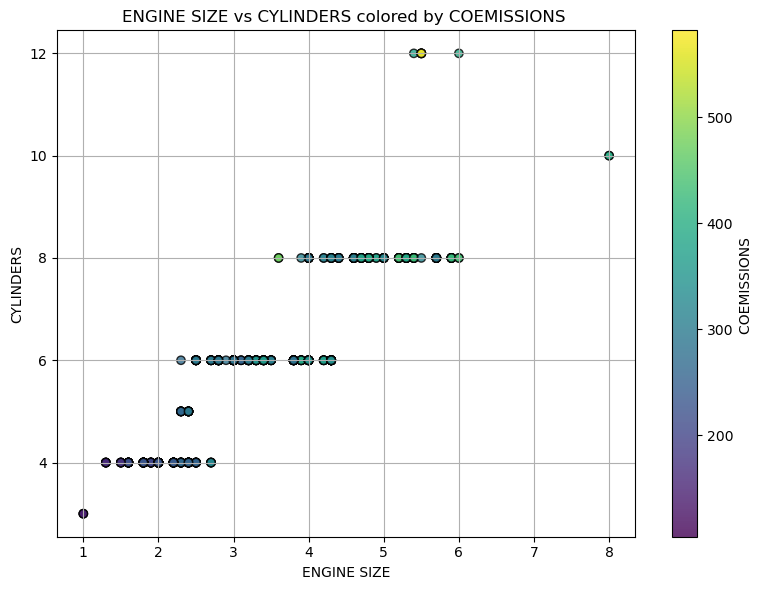

In [11]:
f1, f2 = results[4]["features"]
print(f"5th Best (and 2nd Worst) Combo: {f1} + {f2}")
evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=True)
plot_feature_pair_with_emissions(df, f1, f2, target="COEMISSIONS ")


Worst Combo: ENGINE SIZE + FUEL_ENCODED


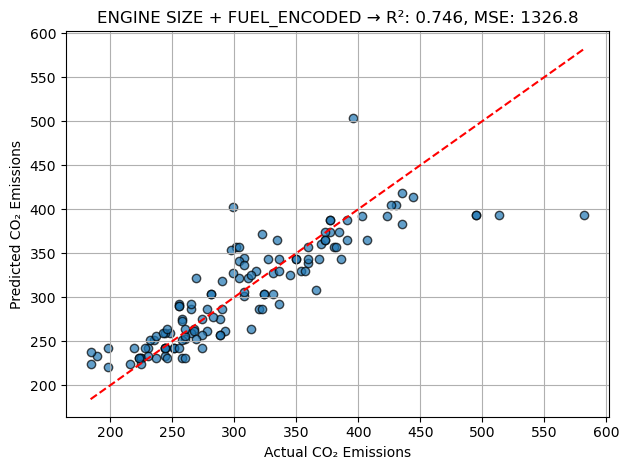

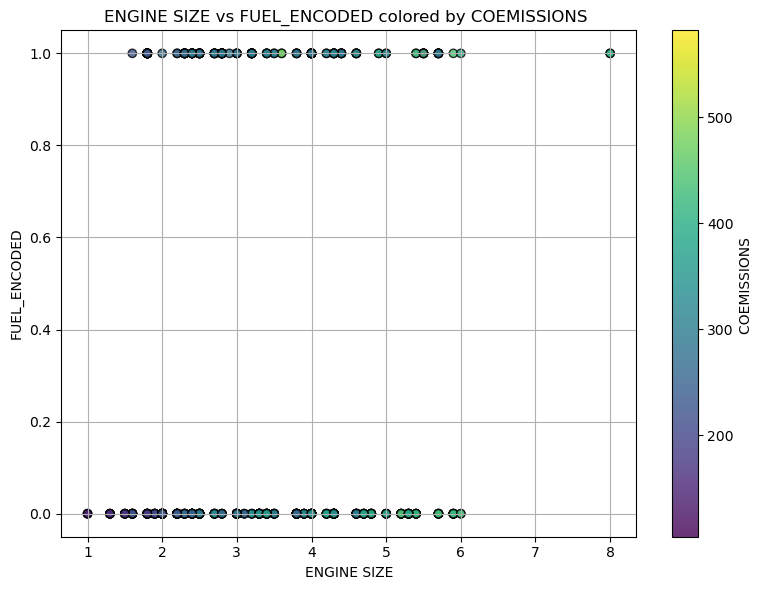

In [12]:
f1, f2 = results[5]["features"]
print(f"Worst Combo: {f1} + {f2}")
evaluate_linear_regression(df, f1, f2, target="COEMISSIONS ", plot=True)
plot_feature_pair_with_emissions(df, f1, f2, target="COEMISSIONS ")

Clearly, with regard to the first kinds of plots, which show the R^2 score and MSE, as the scores decrease, the dots do appear to be further from the dashed red line (x=y). This is because the model was perfectly accurate, the predictions (on y-axis) and the actual value (on x-axis) would match at every point, meaning all points would be on the x=y line.

The second type of plot is a bit harder, visually, to understand, especially when many dots occupy one or a few close together spots on the scatter plot. However, taking a look at the 3rd best result, that garnered from the engine size and fuel consumption features, we can imagine what the linear regression is doing. The plot shows that points get brighter as they go towards the top right of the graph; we can think of the brighter color as height in 3D space. The linear regression is then able to find a 2D plane that goes through, or close to, all of these points, in such a good way that the R^2 score is close to 1. 

## Analysis and Discussion

The goal of this experiment was to evaluate how well different pairs of features could predict vehicle CO₂ emissions using two-variable linear regression. We tested all 2-feature combinations among four key predictors: ENGINE SIZE, CYLINDERS, FUEL CONSUMPTION, and FUEL_ENCODED (a binary encoding of fuel type: regular gasoline = 0, premium = 1). Models were ranked by their R² score, which measures how well each model explains the variance in CO₂ emissions, and also evaluated using mean squared error (MSE), which captures average prediction error in g/km.

The three best-performing feature pairs all included FUEL CONSUMPTION, confirming it as the most directly correlated predictor of CO₂ emissions. The top model (FUEL CONSUMPTION + FUEL_ENCODED) achieved an R² of 0.9851 and an MSE of just 77.67, meaning it could explain over 98% of the variance in emissions with minimal error. This reflects the direct relationship between fuel burned and emissions produced.

At the lower end, combinations that excluded FUEL CONSUMPTION performed considerably worse. For example:

CYLINDERS + FUEL_ENCODED had an R² of 0.7756 (MSE: 1172.36)

ENGINE SIZE + CYLINDERS dropped further to R² = 0.7636 (MSE: 1235.48)

ENGINE SIZE + FUEL_ENCODED was the weakest (R² = 0.7461, MSE: 1326.78)

These combinations still captured a moderate amount of variation, but without direct information about how much fuel is being used, the models struggled to accurately estimate emissions. So, while fuel type and engine characteristics matter, they cannot substitute knowledge of how much fuel the vehicle is actually using for prediction emissions.

All models achieve reasonably high R² scores, suggesting that even simple linear models can be effective for this task with the right inputs.